# 20241122 - Twitter Sentiment Analysis
---
## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Importing Data

In [2]:
def load_df(fp):
	df= pd.read_csv(fp, names=['id', 'ip', 'label', 'text']).set_index('id')
	df.drop_duplicates(inplace=True)
	df.dropna(inplace=True)
	df.info()
	return df

In [3]:
df_trn= load_df('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
print()
df_tst= load_df('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 70958 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      70958 non-null  object
 1   label   70958 non-null  object
 2   text    70958 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 3364 to 6960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      1000 non-null   object
 1   label   1000 non-null   object
 2   text    1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB


In [4]:
df_trn.sample(5)

,ip,label,text
id,,,
4065,CS-GO,Negative,Can’t even solve thiz VAC CSGO issue. :(( . If...
5989,HomeDepot,Positive,"""I said I wasn't going to cry."" Morning. ""Let'..."
13119,Xbox(Xseries),Positive,This link got me my Xbox. I am eternally grate...
11059,TomClancysGhostRecon,Positive,I’m liking the new update for
8320,Microsoft,Positive,"Thank you, @ MSFTImagine & @ IamPablo for send..."


In [5]:
df_trn['label'].value_counts()

label
Negative      21565
Positive      19549
Neutral       17398
Irrelevant    12446
Name: count, dtype: int64

The target labels are somewhat balanced in their distribution. We will avoid `Irrelevant` label for now. 

In [6]:
df_trn= df_trn[df_trn['label']!='Irrelevant']
df_trn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58512 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      58512 non-null  object
 1   label   58512 non-null  object
 2   text    58512 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [7]:
df_tst.sample(5)

,ip,label,text
id,,,
1676,CallOfDutyBlackopsColdWar,Irrelevant,Awesome Gamer
11613,Verizon,Neutral,It was a battle all game long 🤺\n\nAll the bes...
3602,Cyberpunk2077,Irrelevant,#RTXOn\n@Miki21144689 have no one else ^^ but ...
13033,Xbox(Xseries),Irrelevant,How many of you have bought the season 6 battl...
714,ApexLegends,Negative,@PlayApex I have problems to buy the battlepas...


In [8]:
df_tst['label'].value_counts()

label
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

In [9]:
df_tst= df_tst[df_tst['label']!='Irrelevant']
df_tst.info()

<class 'pandas.core.frame.DataFrame'>
Index: 828 entries, 352 to 6960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      828 non-null    object
 1   label   828 non-null    object
 2   text    828 non-null    object
dtypes: object(3)
memory usage: 25.9+ KB


## Preparing the Data

In [10]:
nlp= spacy.load('en_core_web_sm')

In [11]:

# Process text
doc = nlp("Apple is looking at buying a U.K. startup for $1 billion.")

# Tokenization
print([[token.text, token.is_stop, token.is_punct, token.lemma_] for token in doc])

# Named Entity Recognition
for ent in doc.ents:
    print(ent.text, ent.label_)

[['Apple', False, False, 'Apple'], ['is', True, False, 'be'], ['looking', False, False, 'look'], ['at', True, False, 'at'], ['buying', False, False, 'buy'], ['a', True, False, 'a'], ['U.K.', False, False, 'U.K.'], ['startup', False, False, 'startup'], ['for', True, False, 'for'], ['$', False, False, '$'], ['1', False, False, '1'], ['billion', False, False, 'billion'], ['.', False, True, '.']]
Apple ORG
U.K. GPE
$1 billion MONEY


In [12]:
def process_text(s):
	out= []
	for token in nlp(s):
		if not token.is_stop and not token.is_punct:
			out.append(token.lemma_)
	return ' '.join(out)

In [13]:
df_trn['fltr']= df_trn['text'].apply(process_text)

In [14]:
df_trn.sample(5)

,ip,label,text,fltr
id,,,,
10195,PlayerUnknownsBattlegrounds(PUBG),Negative,Hello RhandlerR RhandlerR RhandlerR I can't ac...,hello rhandlerr rhandlerr rhandlerr access pub...
11365,TomClancysRainbowSix,Neutral,A bit scary but a tiny dink _ 3 1 @FearRTs @Mi...,bit scary tiny dink 3 1 @fearrts @Mighty_Rts @...
2371,CallOfDuty,Negative,thinking abt then i were 11/12 and i got rlly ...,think abt 11/12 get rlly duty zombie help para...
8405,NBA2K,Positive,This Sht is so smooth. Then [UNK],Sht smooth unk
2517,Borderlands,Positive,Actually. I think Borderlands 3 could be my fi...,actually think Borderlands 3 fifth favorite Go...


In [15]:
df_tst['fltr']= df_tst['text'].apply(process_text)

In [16]:
df_tst.sample(5)

,ip,label,text,fltr
id,,,,
3058,Dota2,Positive,3.7k to 3.2k 🙃 I LOVE DOTA 2 PUTANG INA,3.7k 3.2k 🙃 love dota 2 putang ina
2103,CallOfDuty,Positive,Really!!!!!! @CallofDuty @InfinityWard #Callof...,@CallofDuty @InfinityWard CallofDuty Warzone M...
9029,Nvidia,Negative,Anyone notice the ratio between conferred buy ...,notice ratio confer buy vs review 3080 3090 ca...
7382,LeagueOfLegends,Neutral,Check out my video! #LeagueofLegends | Capture...,check video LeagueofLegends | capture outplay ...
9116,Nvidia,Neutral,Nice 👍 Follow 👉@pcgeekinfo👈\nTwitter 👉@pcgeeki...,nice 👍 Follow 👉 @pcgeekinfo 👈 \n Twitter 👉 @pc...


In [17]:
enc= LabelEncoder()
y_trn= enc.fit_transform(df_trn['label'])
y_tst= enc.transform(df_tst['label'])

In [18]:
vct= TfidfVectorizer()
X_trn= vct.fit_transform(df_trn['fltr'])
X_tst= vct.transform(df_tst['fltr'])

## Models Training

In [19]:
def model_report(model, verbose=True):
	model.fit(X_trn, y_trn)

	y_pred=   model.predict(X_tst)
	trnScore= model.score(X_trn, y_trn)
	tstScore= model.score(X_tst, y_tst)
	cm= confusion_matrix(y_tst, y_pred)
	cr= classification_report(y_tst, y_pred)

	if verbose:
		print('Train Score: %f'%trnScore)
		print('Test Score:  %f'%tstScore)
		print('Classification Report:\n', cr)
		ConfusionMatrixDisplay(cm).plot()
		plt.show()
		print()
	
	return {
		'trn': trnScore,
		'tst': tstScore,
		'cm':  cm,
		'cr':  cr,
	}

In [20]:
import datetime

models_dict= {
	'LogisticRegression':     LogisticRegression(max_iter=10_000),
	'Support Vector':         SVC(),
	'KNeighborsCLassifier':   KNeighborsClassifier(),
	'DecisionTreeClassifier': DecisionTreeClassifier(),
	'RandomForestClassifier': RandomForestClassifier(),
	'BaggingClassifier':      BaggingClassifier(),
	'ExtraTreesClassifier':   ExtraTreesClassifier(),
	'AdaBoostClassifier':     AdaBoostClassifier(),
	'XGBClassifier':          XGBClassifier(),
	'CatBoostClassifier':     CatBoostClassifier(verbose=False),
	'LGBMClassifier':         LGBMClassifier(),
}
models= [{'name':k, 'obj':v} for k,v in models_dict.items()]

i= 0
for model in models:
    now = datetime.datetime.now()
    print("Evaluating %s..."%model['name'])
    print("%d/%d models"%(i, len(models)), end='\r')
    re = model.update(model_report(model['obj'], verbose=False))
    i+= 1
    print('it takes for ', datetime.datetime.now()- now, re)

print("%d/%d models evaluated"%(i, len(models)))
print("done")

Evaluating LogisticRegression...
it takes for  0:00:22.691716 None
Evaluating Support Vector...
it takes for  0:27:24.600222 None
Evaluating KNeighborsCLassifier...
it takes for  0:05:38.085295 None
Evaluating DecisionTreeClassifier...
it takes for  0:00:16.160802 None
Evaluating RandomForestClassifier...
it takes for  0:02:40.037835 None
Evaluating BaggingClassifier...
it takes for  0:02:26.284997 None
Evaluating ExtraTreesClassifier...
it takes for  0:03:25.433690 None
Evaluating AdaBoostClassifier...
it takes for  0:00:05.943713 None
Evaluating XGBClassifier...
it takes for  0:00:55.493283 None
Evaluating CatBoostClassifier...
it takes for  0:09:35.692431 None
Evaluating LGBMClassifier...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.702193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131906
[LightGBM] [Info] Number of data poin

## Models Evaluation

In [21]:
pd.DataFrame({
	'Algorithm':           [model['name'] for model in models],
	'Train Score':         [model['trn']  for model in models],
	'Test Score':          [model['tst']  for model in models],
}).set_index('Algorithm').sort_values(by='Test Score', ascending=False)

,Train Score,Test Score
Algorithm,,
Support Vector,0.973305,0.977053
ExtraTreesClassifier,0.978910,0.967391
KNeighborsCLassifier,0.946302,0.966184
RandomForestClassifier,0.978893,0.961353
BaggingClassifier,0.973048,0.942029
LogisticRegression,0.886519,0.928744
DecisionTreeClassifier,0.978910,0.913043
XGBClassifier,0.771910,0.794686
LGBMClassifier,0.754016,0.788647


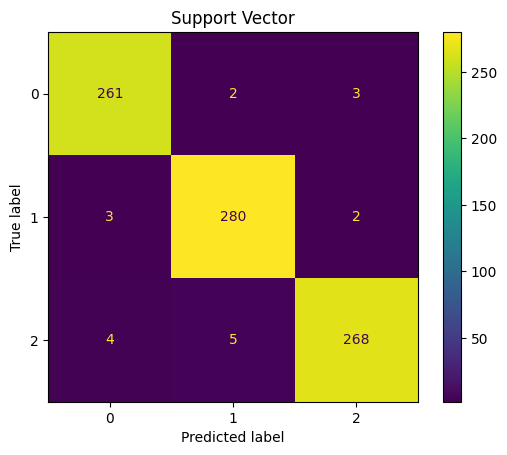

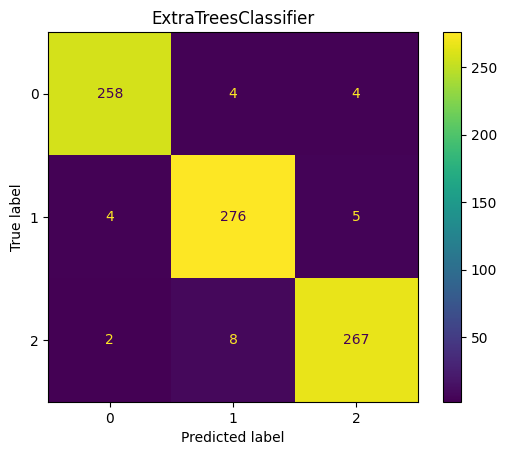

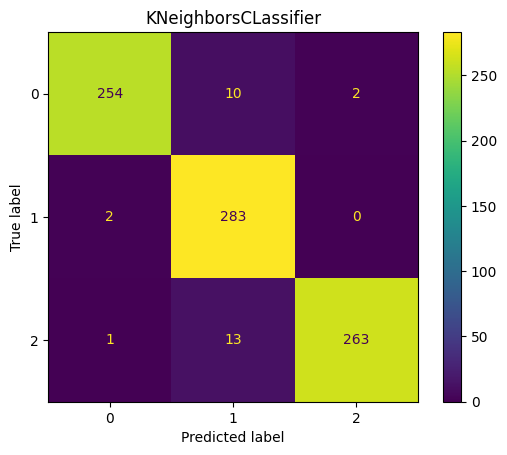

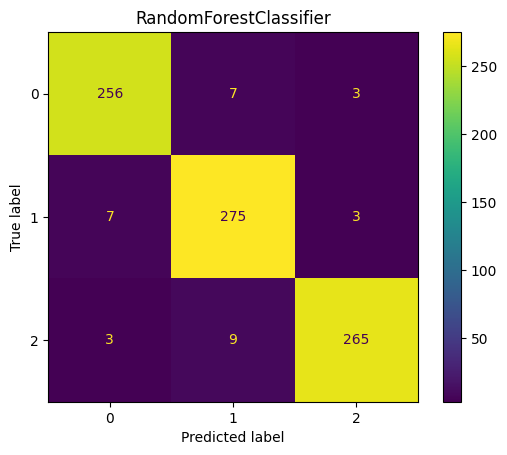

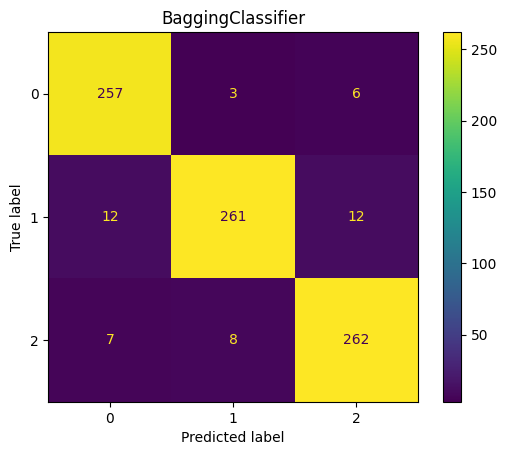

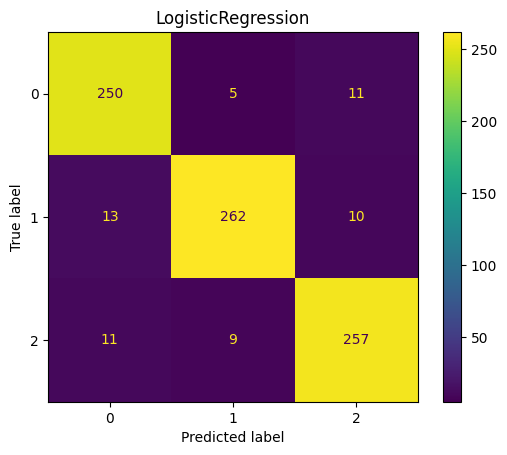

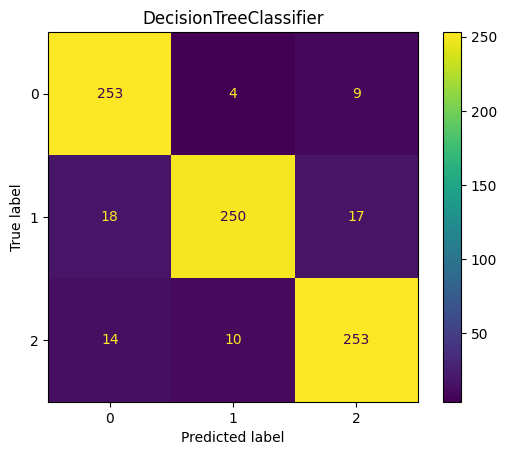

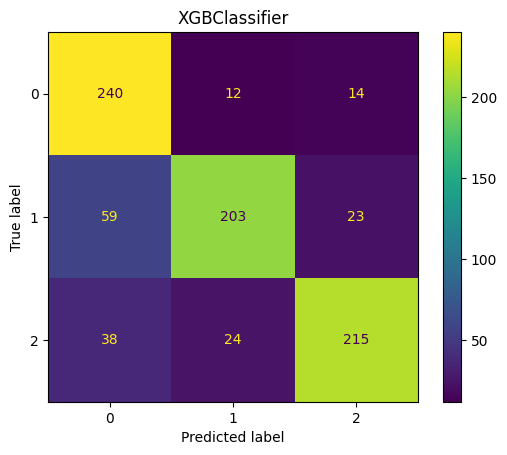

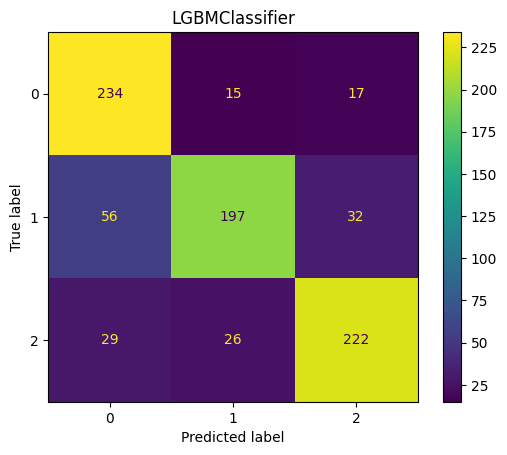

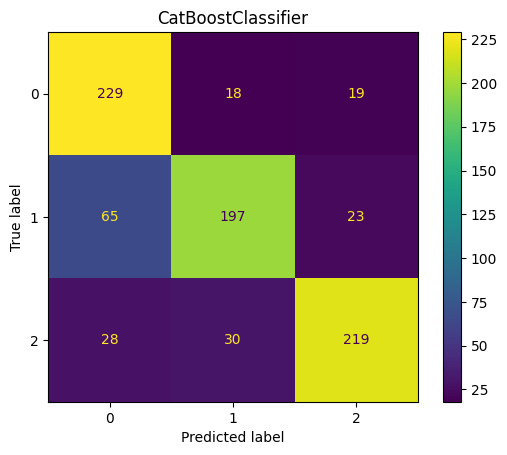

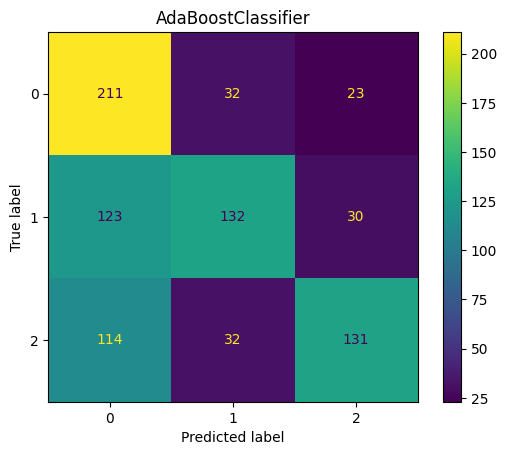

In [22]:
for model in sorted(models, key=lambda x: x['tst'], reverse=True):
	ConfusionMatrixDisplay(model['cm']).plot()
	plt.title(model['name'])